# Microelectromechanical switch

 *************** Created by Pablo Borja *******************
 
 ***** Contact: pablo.borjarosales@plymouth.ac.uk ***** 
 
 ***** SECaM, Univerity of Plymouth, Plymouth, UK ***** 
 

Importing packages...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

from scipy.integrate import solve_ivp

## Parameters for simulation

Parameters of the plant

In [2]:
q0=15e-6;
Ae=35.6e-9; # This parameter is equivalent to the product Aε
m=2.35e-9;
k=0.46;
b=5.5e-7;
r=100;

We choose the desired equilibrium. Remember that the set of assignable equilibria is given by

$$\mathcal{E} = \left\lbrace (q,p,Q)\in\mathbb{R}^{3} \mid q\in(-q_{0},0], \quad p=0, \quad Q 
= \displaystyle\sqrt{-2A\epsilon k\tanh(q)} \right\rbrace.$$

Additionally, remember that this systems must satisfy the constraint $q+q_{0}>0$.

In [3]:
qd = -5e-6; # Modify if necessary
Qd = np.sqrt(-2*Ae*k*np.tanh(qd));


Initial conditions

Modify to simulate different initial conditions


In [4]:
y0 = [0, 0, 0];

Initial and final time

In [5]:
t0 = 0;

tf = 0.005; # Modify if you want to simulate a longer or shorter period

t = np.linspace(t0, tf, 100000)

Control gains 

In [6]:
Ka = 100; # Energy shaping gain
Kdi = 20; # Damping injection gain

## System (ODE)

Below, we briefly explain how to obtain the closed-loop dynamics. Please see the PDF file "Examples" to understand this part.

================================

For implementation purposes, it's simpler to consider the three dynamics independently because only $\dot{Q}$ is affected by the control input. Thus, we can directly implement

$$\begin{array}{rcl}
\dot{q} &=& \frac{p}{m}; \\
\dot{p} &=& -k\tanh(q) - \frac{b}{m}p - \frac{Q^{2}}{2A\epsilon}
\end{array}
$$

Note that

$$F_{\tt uu}=\begin{bmatrix}
0 & 1  \\ -1 & -b \\
    \end{bmatrix}, \qquad F_{\tt au}=\begin{bmatrix}
0 & 0 
    \end{bmatrix}, \qquad F_{\tt aa} = -\frac{1}{r}.$$

Moreover, to comply with Assumption 4, we consider

$$\bar{u} = \frac{u}{r}$$

as the new input.

A suitable choice for $\Phi_{\tt a}(x_{\tt a})$ is given by

$$\Phi_{\tt a}(x_{\tt a}) =K_{\tt a}\left(Q-Q_{\tt d} 
\right)^{2}-\dfrac{(q_{\tt d}+q_{0})}{A\epsilon}QQ_{\tt d},$$

where

$$Q_{\tt d} = \displaystyle\sqrt{-2A\epsilon k\tanh(q_{\star})}.$$

The control is given by (see the paper and the file "Examples")

$$\begin{array}{rcl}
u &=& F_{\tt aa}(x)\frac{\partial \Phi_{\tt a}(x)}{\partial x_{\tt a}}-K_{\tt di}(x)\frac{\partial H_{\tt d}(x)}{\partial x_{\tt a}}- F_{\tt au}(x)\frac{\partial H(x)}{\partial x_{\tt u}}\\
&=& -(\frac{1}{r}+K_{\tt di})\left(K_{\tt a}(Q-Q_{\tt d})-\frac{(q_{\tt d}+q_{0})}{A\epsilon}Q_{\tt d}\right)-K_{\tt di}\frac{(q+q_{0})}{A\epsilon}Q.
\end{array}
$$

To obtain the closed-loop dynamics, we substitute the control law $u$ obtained above into

$$\dot{Q} = -\frac{1}{r}\frac{(q+q_{0})}{A\epsilon}Q+\bar{u}.$$

In [1]:
def mems_ode(t, y, q0, Ae, m, k, b, r, qd, Qd, Ka, Kdi):
    q, p, Q = y
    
    # Controller

    u = -(Kdi+1/r)*(Ka*(Q-Qd) - (qd+q0)*Qd/Ae)-Kdi*Q*(q+q0)/Ae
    
    return [p/m, -b*p/m-k*np.tanh(q)-(Q**2)/(2*Ae),-Q*(q+q0)/(Ae*r)+u]

## ODE solution

In [8]:
sol_ivp = solve_ivp(mems_ode,[t0,tf],y0,args=(q0, Ae, m, k, b, r, qd, Qd, Ka, Kdi), method='LSODA', dense_output=True, rtol = 1e-10, atol = 1e-14)

p = sol_ivp.sol(t)

## Plots

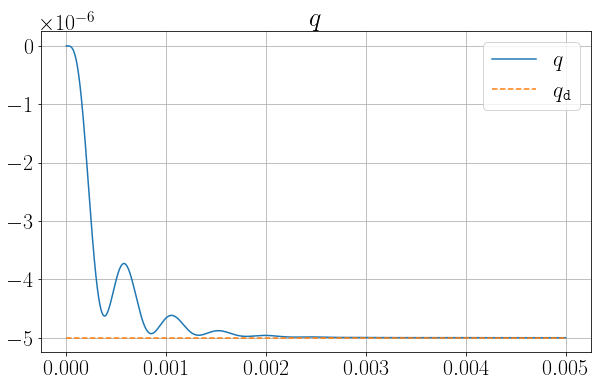

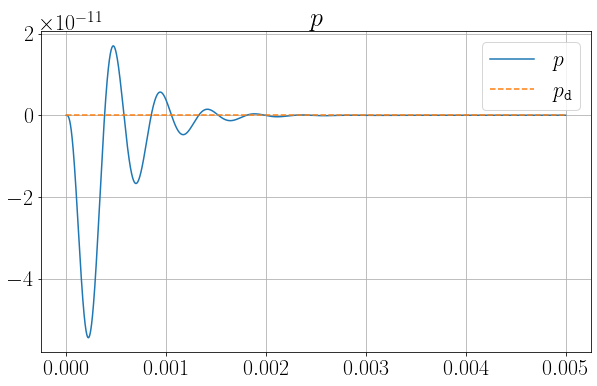

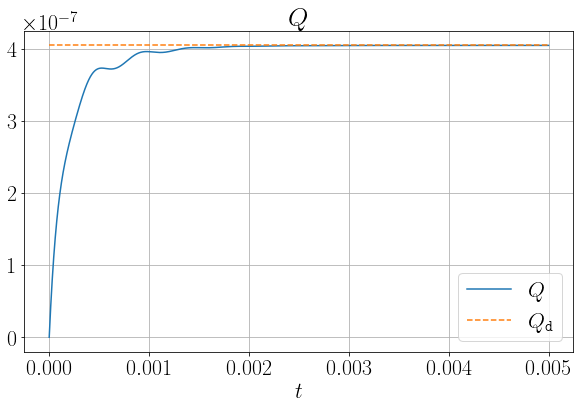

In [9]:
plt.rcParams['text.usetex'] = True
cm = 1/2.54

plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(25*cm, 15*cm))
plt.plot(t, p[0].T, label = '$q$')
plt.plot([t0,tf], [qd,qd],'--',label = '$q_{\\tt d}$')
plt.title('$q$')
plt.grid()
plt.legend(loc='best')


plt.figure(figsize=(25*cm, 15*cm))
plt.plot(t, p[1].T,label = '$p$')
plt.plot([t0,tf], [0,0],'--',label = '$p_{\\tt d}$')
plt.title('$p$')
plt.legend(loc='best')
plt.grid()

plt.figure(figsize=(25*cm, 15*cm))
plt.plot(t, p[2].T,label = '$Q$')
plt.plot([t0,tf], [Qd,Qd],'--',label = '$Q_{\\tt d}$')
plt.title('$Q$')
plt.xlabel('$t$')
plt.legend(loc='best')
plt.grid()
plt.show()